In [78]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# File system manangement
import os

# evalute time
import time

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Pre-processing
from sklearn import preprocessing

import gc

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# Function to reduce the DF size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_memory_size_in_mega_bytes = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_data_type = df[col].dtypes
        if col_data_type in numerics:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_data_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                    
    reduced_df_memory_size_in_mega_bytes = df.memory_usage().sum() / 1024**2
    
    memory_diff = (df_memory_size_in_mega_bytes - reduced_df_memory_size_in_mega_bytes)
    reduce_percent =  (memory_diff / df_memory_size_in_mega_bytes) * 100
    
    if verbose:
        print('Memory usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)' \
              .format(df_memory_size_in_mega_bytes, reduced_df_memory_size_in_mega_bytes, reduce_percent))
        
    return df

In [80]:
# shape of datasets
def get_shape():
    print("Train shape: ", train.shape)
    print("Test shape: ", test.shape)

In [81]:
%%time

base_path = 'C:/Users/VenD/Downloads/ieee-fraud-detection/dataset/'

train_transaction = pd.read_csv(base_path + 'train_transaction.csv')
train_identity = pd.read_csv(base_path + 'train_identity.csv')

test_identity = pd.read_csv(base_path + 'test_identity.csv')
test_transaction = pd.read_csv(base_path + 'test_transaction.csv')

sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

Wall time: 1min 14s


In [82]:
%%time
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage decreased from 1959.88 Mb to 650.48 Mb (66.8% reduction)
Memory usage decreased from 1677.73 Mb to 565.37 Mb (66.3% reduction)
Wall time: 6min 1s


In [83]:
get_shape()

Train shape:  (590540, 434)
Test shape:  (506691, 433)


# Feature Engineering

##  TransactionAmt Decimal Part Feature

In [84]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_Decimal'] = ((train['TransactionAmt'] - train['TransactionAmt']
                                    .astype(int)) * 1000).astype(int)

In [85]:
transaction_amt_decimal_target_df = pd.crosstab(train['TransactionAmt_Decimal'], 
                                                train['isFraud'], normalize='index') * 100
transaction_amt_decimal_target_df = transaction_amt_decimal_target_df.reset_index()
transaction_amt_decimal_target_df.rename(columns={0: 'No Fraud', 1: 'Fraud'}, inplace=True)
transaction_amt_decimal_target_df = transaction_amt_decimal_target_df.sort_values(by='Fraud', ascending=False)[:30]
transaction_amt_decimal_target_df.head(10)

isFraud,TransactionAmt_Decimal,No Fraud,Fraud
146,450,0.000000,100.000000
153,467,0.000000,100.000000
135,424,0.000000,100.000000
158,483,0.000000,100.000000
111,350,0.000000,100.000000
192,583,0.000000,100.000000
148,457,0.000000,100.000000
143,443,12.500000,87.500000
82,263,33.333333,66.666667
32,107,33.333333,66.666667


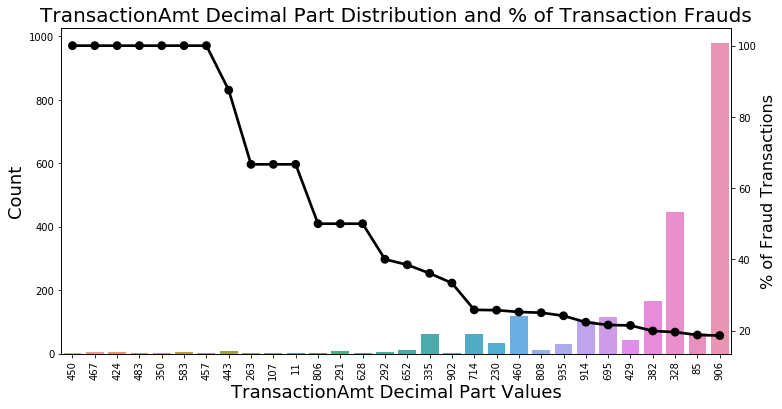

In [86]:
plt.figure(figsize=(12,6))
plt.subplot(111)

ax = sns.countplot(x='TransactionAmt_Decimal', data=train, 
                   order=list(transaction_amt_decimal_target_df.TransactionAmt_Decimal.values))

ax_twin = ax.twinx()
ax_twin = sns.pointplot(x='TransactionAmt_Decimal', y='Fraud', 
                        data=transaction_amt_decimal_target_df, color='black', 
                        order=list(transaction_amt_decimal_target_df.TransactionAmt_Decimal.values))
ax_twin.set_ylabel('% of Fraud Transactions', fontsize=16)

ax.set_title('TransactionAmt Decimal Part Distribution and % of Transaction Frauds', fontsize=20)
ax.set_xlabel('TransactionAmt Decimal Part Values', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Count', fontsize=18)

plt.show()

- percentage of fraud transactions are very high which are very rare and they are in 400's decimal part values. 

In [87]:
# New feature - decimal part of the transaction amount
test['TransactionAmt_Decimal'] = ((test['TransactionAmt'] - test['TransactionAmt']
                                    .astype(int)) * 1000).astype(int)

## TimeDelta Feature

- Let's see if the frauds have some specific hour that has highest % of frauds

- We will assume that **_TransactionDT_** feature is in second. Given a second where a specific transaction occurs. To convert this feature into DateTime feauture, we will assume a **_start date (2017-12-01)_** here and use the delta time to compute datetime features.

In [88]:
def plot_category_count_and_amount_by_fraud_percent(df, col):
    total = len(df)
    # Imp: initially it is in float-16 but after sum, value increase
    # which can't fit into float-16 so it gives error.
    # To solve this issue, cast it into float-64
    df['TransactionAmt'] = df['TransactionAmt'].astype(float)
    total_amt = df['TransactionAmt'].sum()
    
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'No Fraud', 1: 'Fraud'}, inplace=True)
    
    percent_amt = ((df.groupby(['isFraud', col])['TransactionAmt'].sum() / 
                    df.groupby([col])['TransactionAmt'].sum()) * 100).unstack('isFraud')
    
    percent_amt = percent_amt.reset_index()
    percent_amt.rename(columns={0: 'No Fraud', 1: 'Fraud'}, inplace=True)
    percent_amt = percent_amt.fillna(0)
    total_amt_by_category = df.groupby([col])['TransactionAmt'].sum().reset_index()
    
    plt.figure(figsize=(16, 14))
    plt.suptitle(f'{col} Distributions', fontsize=24)
    
    # plot 1
    plt.subplot(211)
    ax1 = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    ax1.set_title(f'{col} Distribution\nCount and %Fraud by each category', fontsize=18)
    ax1.set_xlabel(f'{col} Category Name', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('Count', fontsize=14)
    
    # plot fraud transaction and set only y-axis    
    ax1_twin = ax1.twinx()
    ax1_twin = sns.pointplot(x=col, y='Fraud', data=tmp, 
                             order=list(tmp[col].values),
                             color='black', legend=False)
    ax1_twin.set_ylabel('% of Fraud Transactions', fontsize=14)
    ax1_twin.set_ylim(0, tmp['Fraud'].max() * 1.1)
 
    # set percentages for each bar in graph
    ax1_sizes = []
    
    h_lst = [p.get_height() for p in ax1.patches]
    pad = max(h_lst) * 0.01

    for p in ax1.patches:
        height = p.get_height()
        if np.isnan(height):
            continue
        ax1_sizes.append(height)
        ax1.text(p.get_x() + p.get_width() / 2.0,
                 height + pad,
                 '{:1.2f}%'.format(height / total * 100),
                 ha="center", fontsize=12)
    
    ax1.set_ylim(0, max(ax1_sizes) * 1.15)
    
    # plot 2
    plt.subplot(212)
    ax2 = sns.barplot(x=col, y='TransactionAmt', 
                      data=total_amt_by_category, 
                      order=list(tmp[col].values))
    
    ax2.set_title(f'{col} by Transactions Total + %of total and %Fraud Transactions', fontsize=18)
    ax2.set_xlabel(f'{col} Category Name', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('Transaction Total Amount (U$)', fontsize=14)
    
    # plot fraud transaction amount and set only y-axis
    ax2_twin = ax2.twinx()
    ax2_twin = sns.pointplot(x=col, y='Fraud', data=percent_amt, 
                             order=list(tmp[col].values),
                             color='black', legend=False)
    ax2_twin.set_ylabel('%Fraud Total Amount', fontsize=14)
    ax2_twin.set_ylim(0, percent_amt['Fraud'].max() * 1.1)
    
    # set percentages for each bar in graph
    ax2_sizes = []
    
    h_lst = [p.get_height() for p in ax2.patches]
    pad = max(h_lst) * 0.01
    
    for p in ax2.patches:
        height = p.get_height()
        if np.isnan(height):
            continue
        ax2_sizes.append(height)
        ax2.text(p.get_x() + p.get_width() / 2.0,
                 height + pad,
                 '{:1.2f}%'.format(height / total_amt * 100),
                 ha="center", fontsize=12)
    
    plt.subplots_adjust(hspace=.4, top = 0.9)
    
    plt.show()

In [89]:
from datetime import datetime, timedelta

START_DATE = '2017-01-12'
start_date = datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: start_date + timedelta(seconds=x))

In [90]:
train['Weekdays'] = train['Date'].dt.dayofweek
train['Hours'] = train['Date'].dt.hour
train['Days'] = train['Date'].dt.day

## Month Days Distribution

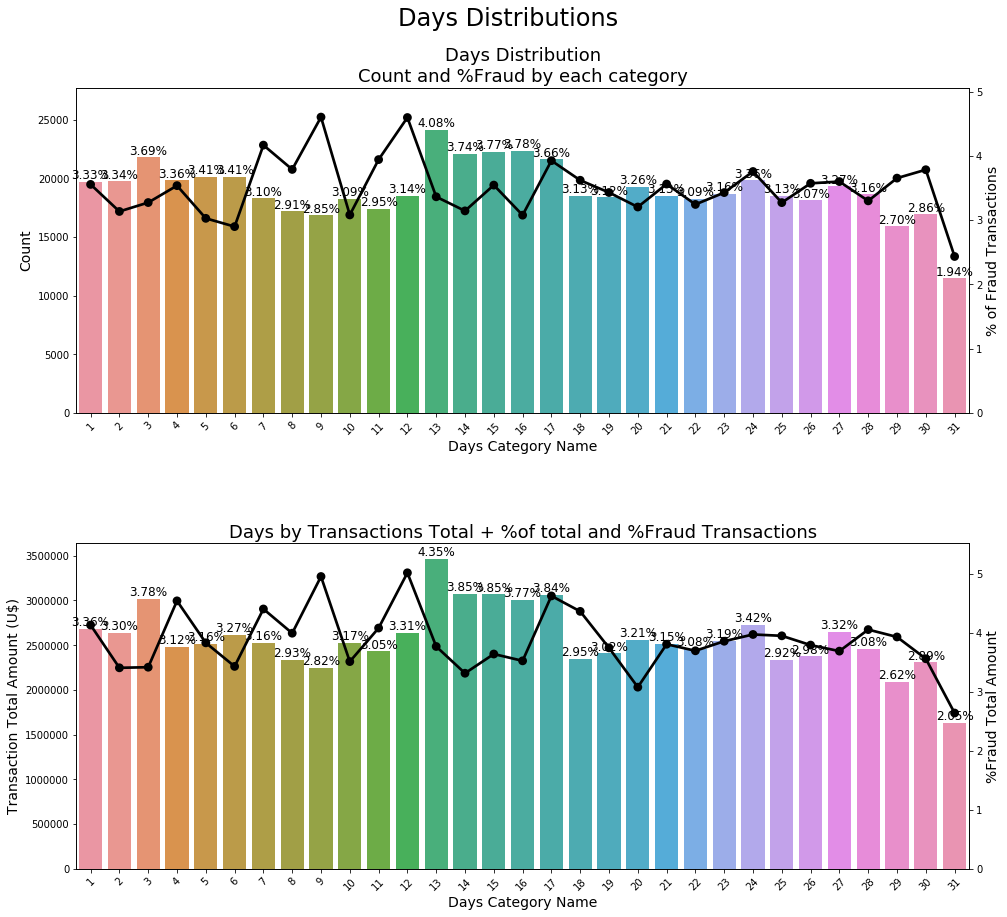

In [91]:
plot_category_count_and_amount_by_fraud_percent(train, 'Days')

## WeekDays Distribution

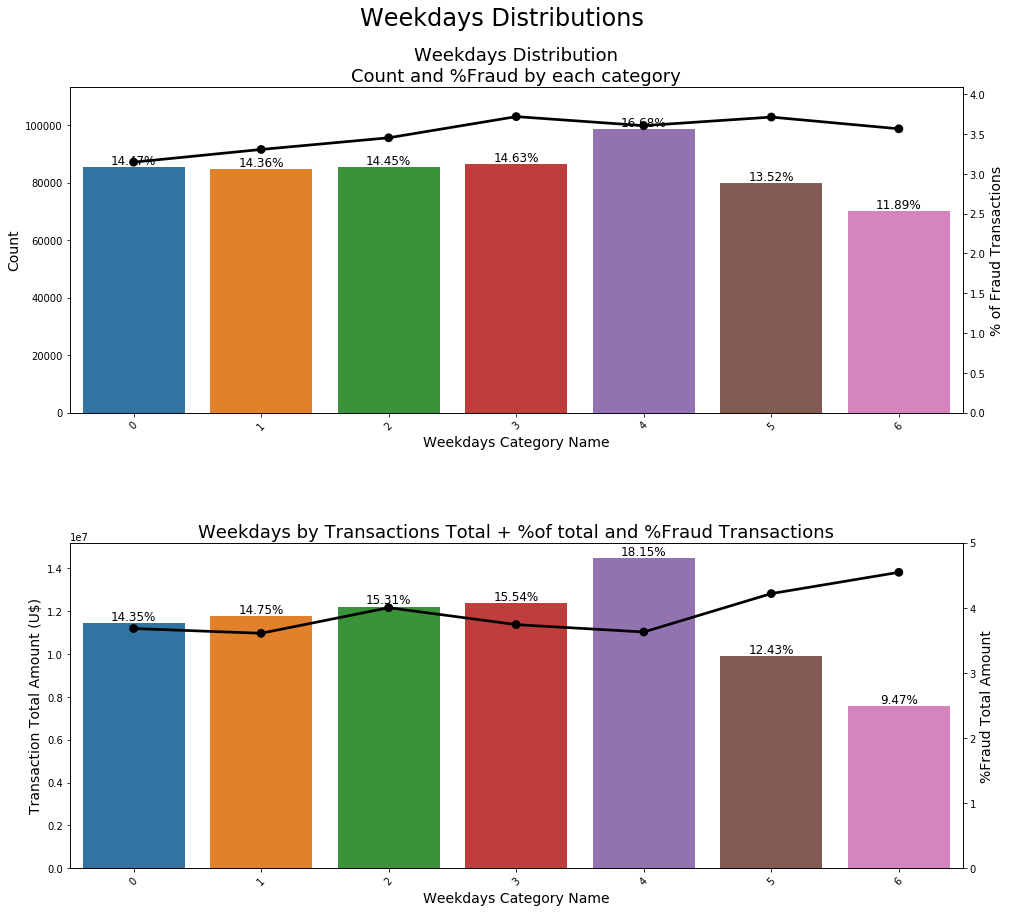

In [92]:
plot_category_count_and_amount_by_fraud_percent(train, 'Weekdays')

## Hours Distribution

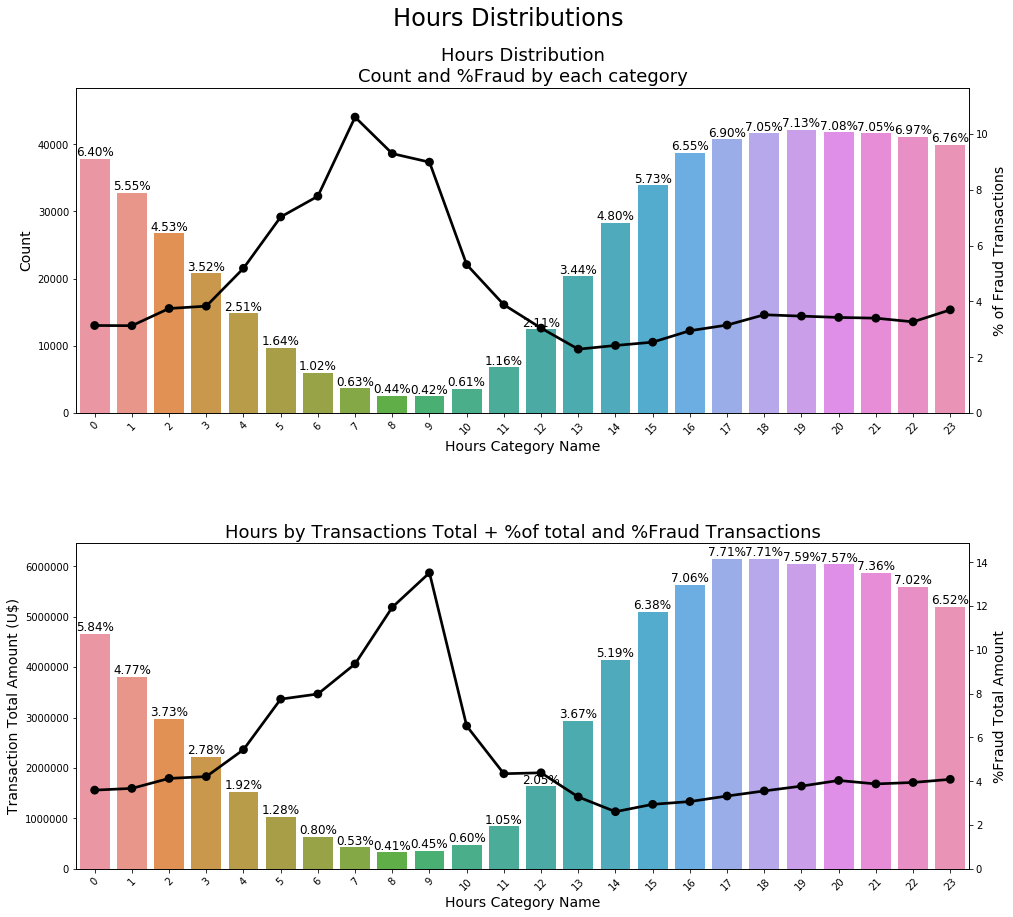

In [93]:
plot_category_count_and_amount_by_fraud_percent(train, 'Hours')

In [94]:
# Make Timedelta features for test set
test['Date'] = test['TransactionDT'].apply(lambda x: start_date + timedelta(seconds=x))

test['Weekdays'] = test['Date'].dt.dayofweek
test['Hours'] = test['Date'].dt.hour
test['Days'] = test['Date'].dt.day

In [96]:
get_shape()

Train shape:  (590540, 439)
Test shape:  (506691, 438)


## DateTime Aggregate Features

In [97]:
def numeric_agg(group_by_col, target_col, df):
    
    
    grouped = df.groupby([group_by_col])[target_col].agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    col_names = [group_by_col]
    for col_name in grouped.columns.values[1:]:
        col_names.append(group_by_col + '_' + col_name)

    grouped.columns = col_names

    df = df.merge(grouped, on=group_by_col, how='left')
        
    return df

In [101]:
train = numeric_agg('Weekdays', 'TransactionAmt', train)
test = numeric_agg('Weekdays', 'TransactionAmt', test)

In [98]:
train = numeric_agg('Hours', 'TransactionAmt', train)
test = numeric_agg('Hours', 'TransactionAmt', test)

In [103]:
train = numeric_agg('Days', 'TransactionAmt', train)
test = numeric_agg('Days', 'TransactionAmt', test)

In [105]:
get_shape()

Train shape:  (590540, 454)
Test shape:  (506691, 453)


In [106]:
train.ProductCD.value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [100]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,TransactionAmt_Decimal,Date,Weekdays,Hours,Days,Hours_count,Hours_mean,Hours_max,Hours_min,Hours_sum
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,500,2017-01-13 00:00:00,4,0,13,37795,123.309691,4300.0,0.569824,4.660490e+06
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0,2017-01-13 00:00:01,4,0,13,37795,123.309691,4300.0,0.569824,4.660490e+06
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0,2017-01-13 00:01:09,4,0,13,37795,123.309691,4300.0,0.569824,4.660490e+06
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0,2017-01-13 00:01:39,4,0,13,37795,123.309691,4300.0,0.569824,4.660490e+06
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0,2017-01-13 00:01:46,4,0,13,37795,123.309691,4300.0,0.569824,4.660490e+06


In [7]:
def one_unique_value_features(df):
    one_value_cols = [col for col in df if df[col].nunique() == 1]
    
    return one_value_cols

def missing_value_features(df, threshold = 0.0):
    missing_value_cols = [col for col in df if (df[col].isnull().sum() / df.shape[0]) > threshold]
    
    return missing_value_cols

def frequent_value_features(df, threshold = 0.0):
    frequent_top_value_cols = [col for col in df if df[col].value_counts(dropna=False, normalize=True).values[0] > threshold]
    
    return frequent_top_value_cols

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    miss_val = df.isnull().sum()
    
    # Percentage of missing values
    miss_val_percent = (miss_val / len(df)) * 100
    
    # Make a table with the results
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis = 1)
    
    # Rename the columns
    miss_val_table_ren_cols = miss_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort (descending) the table by percentage of missing
    sorted_miss_val_table = miss_val_table_ren_cols[miss_val_table_ren_cols.iloc[:, 0] != 0]. \
                            sort_values('Missing Values', ascending = False).round(1)
    
    # Print some summary information
    print("Your selected dataframe has {} columns.\nThere are {} columns that have missing values."
          .format(df.shape[1], miss_val_table_ren_cols.shape[0]))
    
    # Return the dataframe with missing information
    return sorted_miss_val_table

In [9]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 434 columns.
There are 434 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
id_26,585377,99.1
id_27,585371,99.1
id_23,585371,99.1
id_22,585371,99.1
dist2,552913,93.6


In [10]:
# Number of each type of column
train.dtypes.value_counts()

float16    354
float32     45
object      31
int32        2
int16        1
int8         1
dtype: int64

In [12]:
# Number of unique classes (categories) in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ProductCD           5
card4               4
card6               4
P_emaildomain      59
R_emaildomain      60
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
id_12               2
id_15               3
id_16               2
id_23               3
id_27               2
id_28               2
id_29               2
id_30              75
id_31             130
id_33             260
id_34               4
id_35               2
id_36               2
id_37               2
id_38               2
DeviceType          2
DeviceInfo       1786
dtype: int64

In [17]:
# drop columns which have more than 90% missing values
cols_to_drop = list(missing_values[missing_values['% of Total Values'] >= 90.0].index)

In [19]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [20]:
print(train.shape)
print(test.shape)

(590540, 422)
(506691, 421)


In [21]:
# Author: Abdur Rehman

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder():
    """Transform categorical features into a given encoding scheme."""

    def __init__(self, encoding_type='mean', n_folds=5):
        self.encoding_type = encoding_type
        self.n_folds = n_folds
        
    def label_encoding(self, train_df, test_df, cols):
        # Create a label encoder object
        le = LabelEncoder()

        # Iterate through the columns
        for col in cols:
            # Train on the training data
            le.fit(train_df[col])
            # Transform both training and testing data
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])
            
        return train_df, test_df
    
    def one_hot_encoding(self, train_df, test_df, target):
        # one-hot encoding of categorical variables
        train_df = pd.get_dummies(train_df) 
        test_df = pd.get_dummies(test_df)
        
        train_labels = train_df[target]

        # Align the training and testing data, keep only columns present in both dataframes
        train_df, test_df = train_df.align(test_df, join='inner', axis=1)

        # Add the target back in
        train_df[target] = train_labels
        
        return train_df, test_df


    def likelihood_encoding(self, data):
        encoding = data.mean()
        return encoding

    def weight_of_evidence_encoding(self, data):
        ones_count = data.sum()
        zeros_count = data.size - ones_count
        
        # make demoninator valid
        if zeros_count == 0:
            zeros_count = 1
        
        encoding = np.log((ones_count / zeros_count) + 1) * 100
        return encoding

    def count_encoding(self, data):
        encoding = data.sum()
        return encoding

    def diff_encoding(self, data):
        ones_count = data.sum()
        zeros_count = data.size() - ones_count
        encoding = (ones_count - zeros_count).abs()
        return encoding

    def KFold_target_encoding(
        self, 
        train_df, 
        test_df, 
        target, 
        features,
        n_folds=None, 
        encoding_type=None,
    ):
        """ 
        Transform categorical features of train and test dataframe 
        into given target encoding using KFold cross-validation.

        Parameters
        ----------
        train_df : dataframe-like, shape (n_samples, n_features)
            Train Dataframe of categorical features to be encoded.

        test_df : dataframe-like, shape (n_samples, n_features)
            Test Dataframe of categorical features to be encoded.

        features : list-like
            Names of categorical columns to be encoded.

        n_folds: int
            No. of folds used for finding encoding of categorical features.

        encoding_type: str, {'mean', 'evidence', 'count', 'diff'}
            Encoding type to encode categorical features.

        Returns
        -------
        DataFrame
            Encoded categorical features of train and test set.
        """

        if n_folds is None:
            n_folds = self.n_folds

        if encoding_type is None:
            encoding_type = self.encoding_type

        # select the appropriate encoding function
        agg_func = None
        if encoding_type == 'mean':
            agg_func = self.likelihood_encoding
        elif encoding_type == 'evidence':
            agg_func = self.weight_of_evidence_encoding
        elif encoding_type == 'count':
            agg_func = self.count_encoding
        elif encoding_type == 'diff':
            agg_func = self.diff_encoding

        kf = KFold(n_splits=n_folds)
    
        # copy features for mean encoding
        for feature in categorical_features:
            train_df[feature + '_' + encoding_type + '_target'] = train_df[feature]
            test_df[feature + '_' + encoding_type + '_target'] = test_df[feature]
    
        # populate features of train set with mean encoding
        for train_index, valid_index in kf.split(train_df):
            train_data = train_df.iloc[train_index]
        
            for feature in features:
                feature_encoding = train_data.groupby([feature])[target].apply(agg_func)
                
                train_df[feature + '_' + encoding_type + '_target'].iloc[valid_index] = \
                train_df[feature + '_' + encoding_type + '_target'].iloc[valid_index].map(feature_encoding)
                    
        # populate features of test set with mean encoding
        for feature in features:
            train_df[feature + '_' + encoding_type + '_target'] = \
            pd.to_numeric(train_df[feature + '_' + encoding_type + '_target'])

            feature_encoding = train_df.groupby([feature])[feature + '_' + encoding_type + '_target'] \
                                .apply(agg_func)
            test_df[feature + '_' + encoding_type + '_target'] = \
            test_df[feature + '_' + encoding_type + '_target'].map(feature_encoding)
            

        train_df = train_df.drop(features, axis=1)
        test_df = test_df.drop(features, axis=1)
    
        return train_df, test_df

In [22]:
cg = CategoricalEncoder()

In [23]:
target = 'isFraud'
categorical_features = list(train.select_dtypes(include='object').columns.values)
train, test = cg.KFold_target_encoding(train, test, target, categorical_features)

In [24]:
y_train = train['isFraud'].copy()
X_train = train.drop(['TransactionID', 'isFraud'], axis = 1)

X_test = test.drop(['TransactionID'], axis = 1)

del train, test

print(X_train.shape)
print(X_test.shape)

(590540, 420)
(506691, 420)


In [25]:
import gc
from time import time
import datetime
import pandas as pd

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score

class TrainXGBoost:
    def __init__(
        self, 
        params,
        X_train,
        y_train,
        X_test,
        submission,
        target,
        metric,
        early_stopping_rounds=50,
        n_folds=5,
        verbose=True
    ):
        self.params = params
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.submission = submission
        self.target = target
        self.verbose = verbose
        self.n_folds = n_folds
        self.metric = metric
        self.early_stopping_rounds = early_stopping_rounds
        self.feature_importances = pd.DataFrame()
        self.train_aucs = []
        self.valid_aucs = []
        
    def train_model(self):
        # KFold for cross-validation
        folds = KFold(n_splits=self.n_folds)
        
        self.submission[target] = 0
            
        training_start_time = time()
        for fold, (train_index, valid_index) in enumerate(folds.split(self.X_train)):
            start_time = time()
            print('Training on Fold {}'.format(fold + 1))

            model = XGBClassifier(**self.params)
            
            # make train and valid set
            X_train, X_valid = self.X_train.iloc[train_index], self.X_train.iloc[valid_index]
            y_train, y_valid = self.y_train.iloc[train_index], self.y_train.iloc[valid_index]

            # train the model
            model.fit(
                X_train, 
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric=self.metric,
                early_stopping_rounds=self.early_stopping_rounds,
                verbose=self.verbose,
            )
            
            train_pred = model.predict_proba(X_train)[:, 1]
            del X_train
    
            valid_pred = model.predict_proba(X_valid)[:, 1]
            del X_valid

            # train and valid roc_auc
            self.train_aucs.append(roc_auc_score(y_train, train_pred))
            self.valid_aucs.append(roc_auc_score(y_valid, valid_pred))
            
            del y_train, train_pred
            del y_valid, valid_pred
            
            print('ROC AUC on Train: {}'.format(self.train_aucs[fold]))
            print('ROC AUC on Validation: {}'.format(self.valid_aucs[fold]))
            
            # test set predictions for KFold
            test_pred = model.predict_proba(self.X_test)[:, 1]
            self.submission[self.target] = self.submission[self.target] + test_pred / self.n_folds

            gc.collect()
            
            print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
            print("=" * 30)
            print()

            self.feature_importances['fold_{}'.format(fold + 1)] = pd.Series(model.get_booster().get_fscore())
            
        print('-' * 30)
        print('Training has finished!')
        print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
        print('Mean AUC on Train: ', np.mean(self.train_aucs))
        print('Mean AUC on Validation: ', np.mean(self.valid_aucs))
        print('-' * 30)
            
        return model
    
    def get_feature_importances(self):
        self.feature_importances['average'] = self.feature_importances.mean(axis=1)
        return self.feature_importances
    
    def auc_score(self):
        folds = ['fold_{}'.format(fold+1) for fold in range(self.n_folds)]
        auc_df = pd.DataFrame({
            'Fold_no': folds,
            'Train AUC': self.train_aucs,
            'Valid AUC': self.valid_aucs,
        })
        
        auc_df.set_index('Fold_no', inplace=True)
        
        return auc_df

In [26]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'n_jobs': 4,
    'scale_pos_weight': 1,
    'seed': 27
}

target = 'isFraud'

submission = sample_submission.copy()

txgb = TrainXGBoost(params, X_train, y_train, X_test, submission, target, 'auc', n_folds=5, verbose=False)

In [27]:
model = txgb.train_model()

Training on Fold 1
ROC AUC on Train: 0.9707007604557042
ROC AUC on Validation: 0.9094247233342067
Fold 1 finished in 0:37:03.678434

Training on Fold 2
ROC AUC on Train: 0.9795411439832684
ROC AUC on Validation: 0.9272782241613658
Fold 2 finished in 0:51:36.950549

Training on Fold 3
ROC AUC on Train: 0.9735801380675346
ROC AUC on Validation: 0.9174931741578735
Fold 3 finished in 0:42:03.359354

Training on Fold 4
ROC AUC on Train: 0.9732581584242073
ROC AUC on Validation: 0.9353772936658905
Fold 4 finished in 0:44:57.175941

Training on Fold 5
ROC AUC on Train: 0.9678079422261636
ROC AUC on Validation: 0.9089927606767743
Fold 5 finished in 0:37:02.067043

------------------------------
Training has finished!
Total training time is 3:32:43.818884
Mean AUC on Train:  0.9729776286313756
Mean AUC on Validation:  0.9197132351992222
------------------------------


In [45]:
# Author: Abdur Rehman

# ==========================================================================
# In each step of tuning, we will use the tuned paramters of previous step
# ==========================================================================

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import gc

class TuneXGBoost:
    def __init__(
        self,
        X_train,
        y_train,
        n_folds=5,
        early_stopping_rounds=50,
    ):
        self.params = {
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 5,
            'min_child_weight': 1,
            'gamma': 0,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'binary:logistic',
            'n_jobs': -1,
            'scale_pos_weight': 1,
            'reg_alpha': 0,
            'seed': 27
        }
        
        self.X_train = X_train
        self.y_train = y_train
        self.cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=27)
        self.early_stopping_rounds = early_stopping_rounds
        
    def update_params_dict(self, params):
        for param_name, param_val in params.items():
            self.params[param_name] = param_val
            
        return self.params
    
    def grid_search_cv(self, params_grid):
        grid_search = GridSearchCV(
            estimator=XGBClassifier(**self.params),
            param_grid=params_grid,
            cv=self.cv,
            scoring='roc_auc',
            iid=False,
            verbose=5,
            n_jobs=-1,
        )
        
        grid_search.fit(self.X_train, self.y_train)
        
        update_params = self.update_params_dict(grid_search.best_params_)
        
        grid_search_summary = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
        
        del grid_search
        gc.collect()
        
        return grid_search_summary
    
    def print_logs(self, grid_search_summary, params_grid):
        param_names = ", ".join(list(params_grid.keys()))
        print("\n")
        print("=" * 30)
        print("Hyper-parameteres tuned: ")
        print("Best Params: ", grid_search_summary['best_params'])
        print("Best Score: ", grid_search_summary['best_score'])
        print("=" * 30)
    
    # ===================================================================================================
    # xgb.cv() method takes a lot of memory and crashes the kernel often (tried on both Colab and Kaggle)
    # I will use GridSearch() to tune n_estimators instead xgb.cv()
    # ===================================================================================================
#     def tune_no_of_estimators(self):
#         xgb_data = xgb.DMatrix(self.X_train.values, label=self.y_train.values)
#         cv_result = xgb.cv(self.params, xgb_data, 
#                            num_boost_round=self.params['n_estimators'], 
#                            nfold=self.n_folds, metrics='auc', 
#                            early_stopping_rounds=self.early_stopping_rounds, 
#                            verbose_eval=50)
        
#         print("Optimal no. of trees: ", cv_result.shape[0])


    def tune_no_of_estimators(self, n_estimators_range=None):
        if n_estimators_range is None:
            n_estimators_range = list(range(100, 1000, 100))
            
        params_grid = {
            'n_estimators': n_estimators_range,
        }
        
        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
        
    def tune_max_depth_and_min_child_weight(self):
        params_grid = {
            'max_depth':list(range(3,12,2)),
            'min_child_weight':list(range(1,12,2)),
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    def narrow_max_depth_and_min_child_weight(self):
        max_depth = self.params['max_depth']
        min_child_weight = self.params['min_child_weight']
        
        params_grid = {
            'max_depth': [max_depth-1, max_depth, max_depth+1],
            'min_child_weight': [min_child_weight-1, min_child_weight, min_child_weight+1],
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    def tune_gamma(self):
        params_grid = {
            'gamma': [i/10.0 for i in range(5)],
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    # =============================================================================================
    # A good idea would be to re-calibrate the number of boosting rounds for the updated parameters.
    # =============================================================================================
        
    def tune_subsample_and_colsample_bytree(self):
        params_grid = {
            'subsample': [i/10.0 for i in range(6,10)],
            'colsample_bytree': [i/10.0 for i in range(6,10)],
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    def narrow_subsample_and_colsample_bytree(self):
        subsample = self.params['subsample']
        colsample_bytree = self.params['colsample_bytree']
        
        params_grid = {
            'subsample': [subsample-0.05, subsample, subsample+0.05],
            'colsample_bytree': [colsample_bytree-0.05, colsample_bytree, colsample_bytree+0.05],
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    def tune_reg_alpha(self):
        params_grid = {
            'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    def narrow_reg_alpha(self):
        reg_alpha = self.params['reg_alpha']
        
        narrow_further = None
        reg_alphas = None
        if reg_alpha <= 0.01 and reg_alpha >= 0.0001:
            reg_alphas = [0, 0.001, 0.005, 0.01, 0.05]
            narrow_further = True
        elif reg_alpha <= 0.1 and reg_alpha > 0.01:
            reg_alphas = [0.05, 0.09, 0.1, 0.2, 0.3]
            narrow_further = True
        elif reg_alpha <=1 and reg_alpha > 0.1:
            reg_alphas = [0.3, 0.8, 1, 1.5, 2]
            narrow_further = True
            
        if narrow_further is None:
            return
        
        params_grid = {
            'reg_alpha': reg_alphas,
        }

        grid_search_summary = self.grid_search_cv(params_grid)
        print_logs(grid_search_summary, params_grid)
        
    # ==============================================================================
    # reduce the learning rate(say 0.01) and add more trees (to get the n_estimators)
    # ==============================================================================

In [46]:
tune_xgb = TuneXGBoost(X_train, y_train)

In [1]:
# tune_xgb.tune_no_of_estimators(n_estimators_range=[2500, 3000, 3500])